# EEE3314-02, Introduction Artificial Intelligence
# Lecture 3. Convolutional Neural Network

In [ ]:
import torch
from torch import nn

#1. The Cross-Correlation Operation

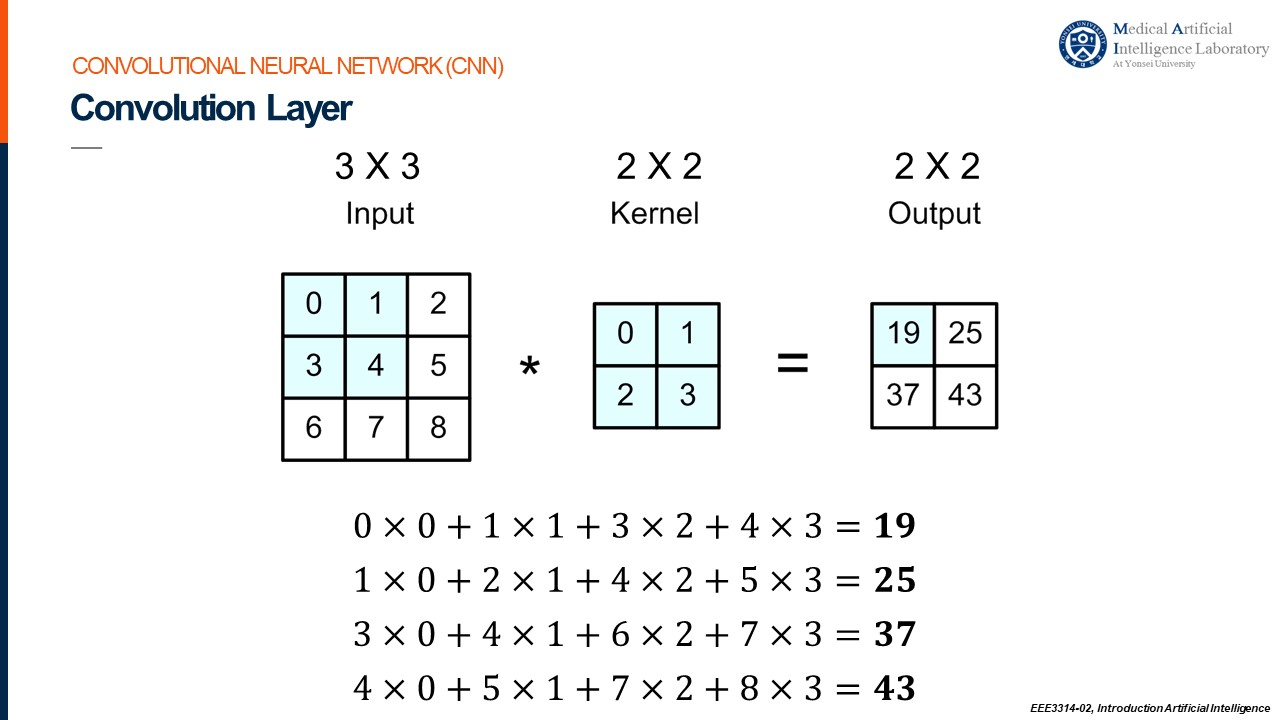

위 cross-correlation operation을 ***corr2d*** 함수로 구현.\
input tensor ***X*** 와 kernel tensor ***K*** 를 받아서 output tensor ***Y*** 를 출력하는 함수.

#**Assignment 3-1**

***corr2d*** 함수 구현하기 \
***X***: input tensor, ***K***: kernel tensor, ***Y***: output tensor

In [ ]:
def corr2d(X, K):
    # Compute 2D cross-correlation
    # X: input tensor, K: kernel tensor
    # Y: output tensor
    [R,C] = X.shape # R ; input tensor row , C : input tensor column
    [r,c] = K.shape # r : kernel tensor row , c : kernel tensor column
    stride = 1
    output_sizeR = int((R-r)/stride + 1) # Y의 row size 계산
    output_sizeC = int((C-c)/stride + 1) # Y의 column size 계산
    Y = torch.zeros(output_sizeR, output_sizeC) # 0으로 구성된 Y 생성
    for i in range(output_sizeR):
      for j in range(output_sizeC):
        for k in range(r):
          for l in range(c):
            Y[i,j] = Y[i,j] + X[i+k,j+l]*K[k,l] #cross correlation 계산
    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]]) # Input tensor
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]]) # Kernel tensor

corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

#2. Convolution Layers

convolution layer는 input과 kernel의 **cross-correlation**을 계산한 뒤 scalar bias를 출력에 더해줌.\
convolution layer의 두 변수: **kernel**, **scalar bias**

In [ ]:
class Conv2D(nn.Module):
    # Compute 2D convolution

    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size)) # weight parameter, random initialization
        self.bias = nn.Parameter(torch.zeros(1)) # bias parameter, zero initialization

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias # cross-correlation + bias

#3. Object Edge Detection in Images

convolution layer를 적용하기 위한 예시.\
pixel 값이 변화하는 위치를 찾아서 image안에 있는 obejct의 edge 찾기.

In [ ]:
X = torch.ones((6, 8)) # X: 6 X 8 image tensor
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [ ]:
K = torch.tensor([[1.0, -1.0]]) # K: 1 X 2 kernel tensor

In [ ]:
Y = corr2d(X, K) # Y: output tensor
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [ ]:
corr2d(X.t(), K) # apply kernel to the transposed image

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

#4. Learning a Kernel

input-output pairs만 가지고서 **kernel**을 학습할 수 있는지 확인.\
위 예시에서 input ***X***와 output ***Y***를 이용하여 kernel ***K***를 학습.

In [ ]:
# Construct a 2D convolution layer with 1 output channel and a kernel of shape (1, 2).
# For simplicity, the bias is ignored here

conv2d = nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False)

# The 2D convolution layer uses 4D input and output in the shape of (batch, channel, height, width).
# The batch size and the number of channels are both 1

X = X.reshape((1, 1, 6, 8)) # X: input tensor
Y = Y.reshape((1, 1, 6, 7)) # Y: output tensor

lr = 3e-2  # Learning rate

for i in range(30):
    Y_hat = conv2d(X) # convolution layer
    l = (Y_hat - Y)**2 # compute l2 norm
    conv2d.zero_grad()
    l.sum().backward() # loss backpropagation

    # update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'batch {i + 1}, loss {l.sum():.5f}')

batch 2, loss 0.47825
batch 4, loss 0.08084
batch 6, loss 0.01381
batch 8, loss 0.00242
batch 10, loss 0.00045
batch 12, loss 0.00009
batch 14, loss 0.00002
batch 16, loss 0.00001
batch 18, loss 0.00000
batch 20, loss 0.00000
batch 22, loss 0.00000
batch 24, loss 0.00000
batch 26, loss 0.00000
batch 28, loss 0.00000
batch 30, loss 0.00000


In [ ]:
conv2d.weight.data.reshape((1, 2)) # trained kernel

tensor([[ 1.0000, -1.0000]])

#5. Padding

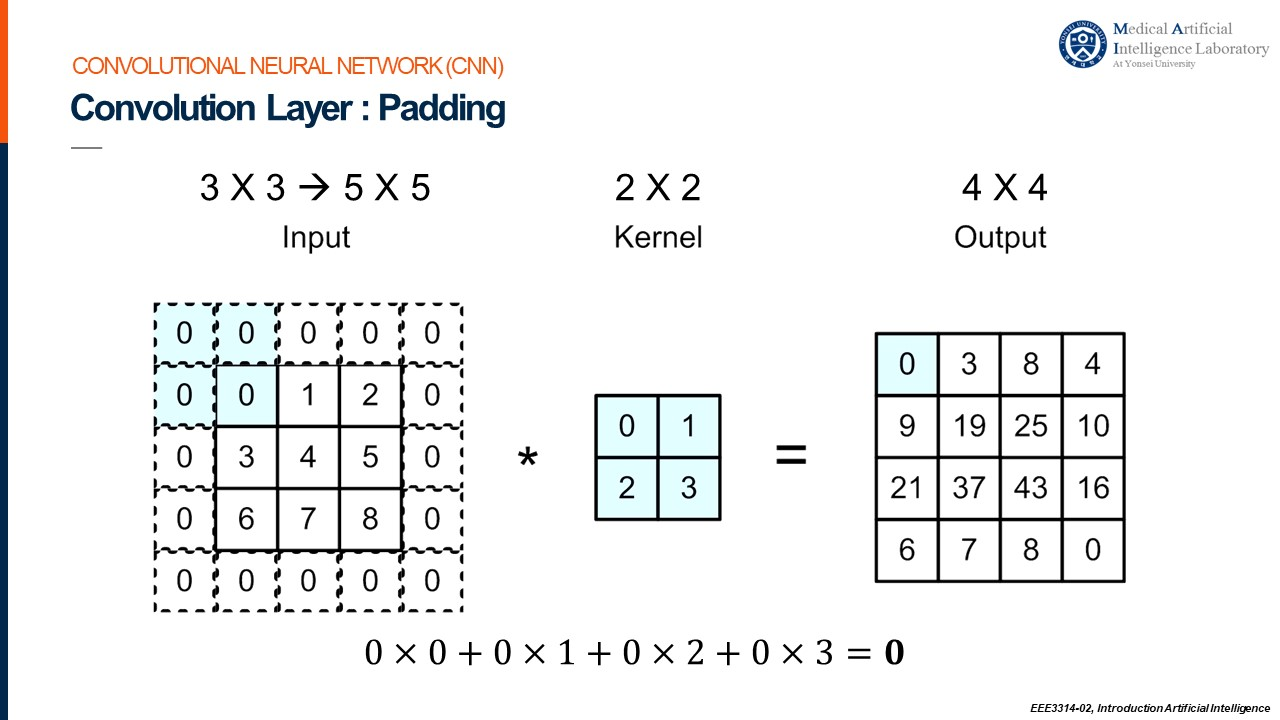

위 padding operation을 ***pad_2d*** 함수로 구현.\
input tensor ***X*** 와 padding size ***P*** 를 받아서 output tensor ***Y*** 를 출력하는 함수.

#**Assignment 3-2**

***pad_2d*** 함수 구현하기 \
***X***: input tensor, ***P***: padding size, ***Y***: output tensor

In [ ]:
def pad_2d(X, P):
    # Compute 2D padding
    # X: input tensor, P: padding size
    [R,C] = X.shape
    r_pad_size = P[0]
    r_pad = torch.zeros(r_pad_size, C)
    Y_yet = torch.cat((r_pad, X, r_pad))
    [nR, nC] = Y_yet.shape
    c_pad_size = P[1]
    c_pad = torch.zeros(nR, c_pad_size)
    Y = torch.cat((c_pad, Y_yet, c_pad),1)
    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]]) # Input tensor
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]]) # Kernel tensor

X_pad = pad_2d(X, (1, 1)) # padding size (1, 1)
X_pad.shape

torch.Size([5, 5])

In [ ]:
corr2d(X_pad, K)

tensor([[ 0.,  3.,  8.,  4.],
        [ 9., 19., 25., 10.],
        [21., 37., 43., 16.],
        [ 6.,  7.,  8.,  0.]])

In [ ]:
# Function that performs corresponding dimensionality elevations and reductions on the input and output
# for the convolution layer.

def comp_conv2d(conv2d, X):
    # Here (1, 1) indicates that the batch size and the number of channels are both 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Exclude the first two dimensions (batch and channels)
    return Y.reshape(Y.shape[2:])

In [ ]:
# For this example, 1 row and 1 column is padded on each side and a total of 2 rows and columns are added.

conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1) # kernel size: 3, padding: 1
X = torch.rand(size=(8, 8)) # input tensor: 8 X 8
comp_conv2d(conv2d, X).shape # output tensor: 8 X 8

torch.Size([8, 8])

In [ ]:
# For this example, 2 rows and 1 column are padded on each side and a total of 4 rows and 2 colums are added.

conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1)) # kernel size: 5 X 3, padding: (2, 1)
comp_conv2d(conv2d, X).shape # output tensor: 8 X 8

torch.Size([8, 8])

#6. Stride

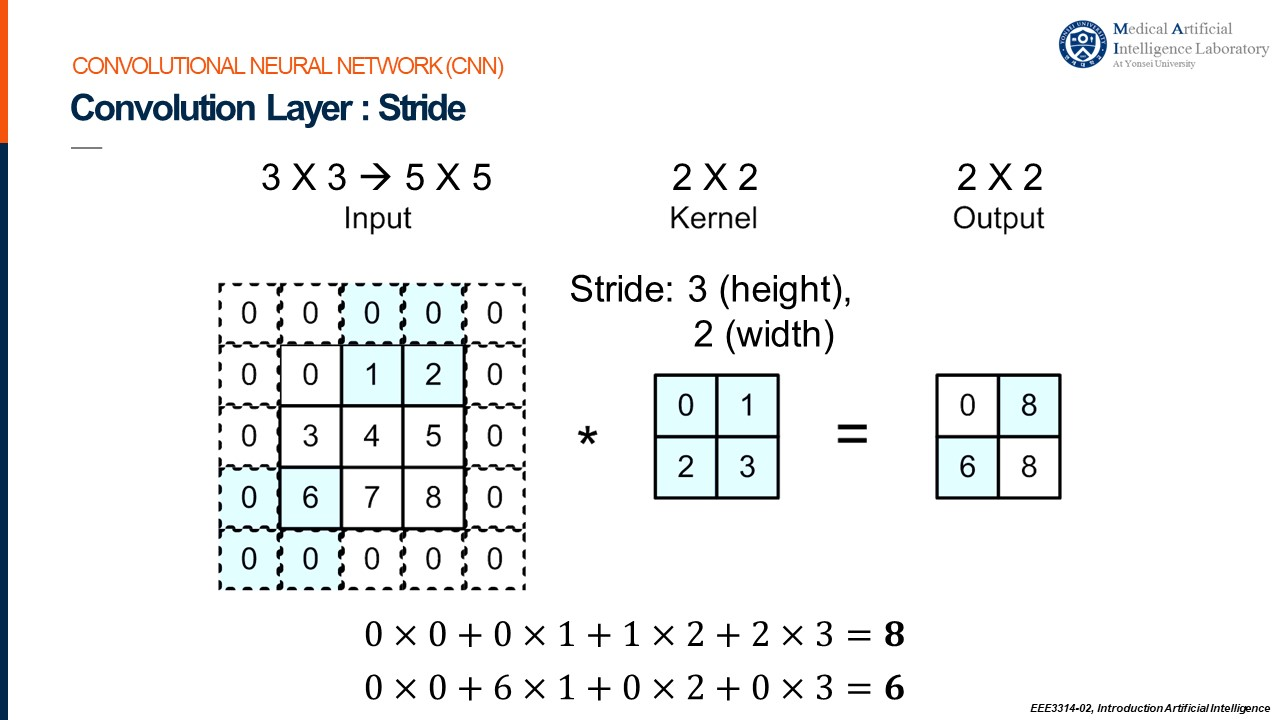

위 stride operation을 ***corr2d_str*** 함수로 구현.\
input tensor ***X***, kernel tensor ***K***, stride ***S*** 를 받아서 output tensor ***Y*** 를 출력하는 함수.

#**Assignment 3-3**

***corr2d_str*** 함수 구현하기 \
***X***: input tensor, ***K***: kernel tensor, ***S***: stride, ***Y***: output tensor

In [ ]:
import math

def corr2d_str(X, K, S):
    # Compute 2D cross-correlation with stride
    # X: input tensor, K: kernel tensor
    # S: stride
    # Y: output tensor
    [R,C] = X.shape # R ; input tensor row , C : input tensor column
    [r,c] = K.shape # r : kernel tensor row , c : kernel tensor column
    S_r = S[0]
    S_c = S[1]
    output_sizeR = int((R-r)/S_r+ 1) # Y의 row size 계산
    output_sizeC = int((C-c)/S_c + 1) # Y의 column size 계산
    Y = torch.zeros(output_sizeR, output_sizeC) # 0으로 구성된 Y 생성
    for i in range(output_sizeR):
      for j in range(output_sizeC):
        for k in range(r):
          for l in range(c):
            Y[i,j] = Y[i,j] + X[i+k,j+l]*K[k,l] #cross correlation 계산
    
    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]]) # Input tensor
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]]) # Kernel tensor

X_pad = pad_2d(X, (1, 1)) # padding size (1, 1)
X_pad.shape

torch.Size([5, 5])

In [ ]:
corr2d_str(X_pad, K, (3, 2)) # stride (3, 2)

In [ ]:
# output tensor size = (N - F)/stride + 1
# N: input tensor size, F: kernel tensor size

# For this example, 1 row and 1 column is padded on each side and a total of 2 rows and columns are added.
# And, convolution kernel (3 X 3) slides over with stride 2.

conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2) # kernel size: 3, padding: 1, stride: 2
X = torch.rand(size=(8, 8)) # input tensor: 8 X 8
comp_conv2d(conv2d, X).shape # output tensor: 4 X 4

In [ ]:
# For this example, 0 row and 1 column is padded on each side and a total of 0 rows and 2 columns are added.
# And, convolution kernel (3 X 5) slides over with stride 3 and 4 for height and width.

conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4)) # kernel size: 3 X 5, padding: (0, 1), stride: (3, 4)
comp_conv2d(conv2d, X).shape # output tensor: 2 X 2

#7. Pooling

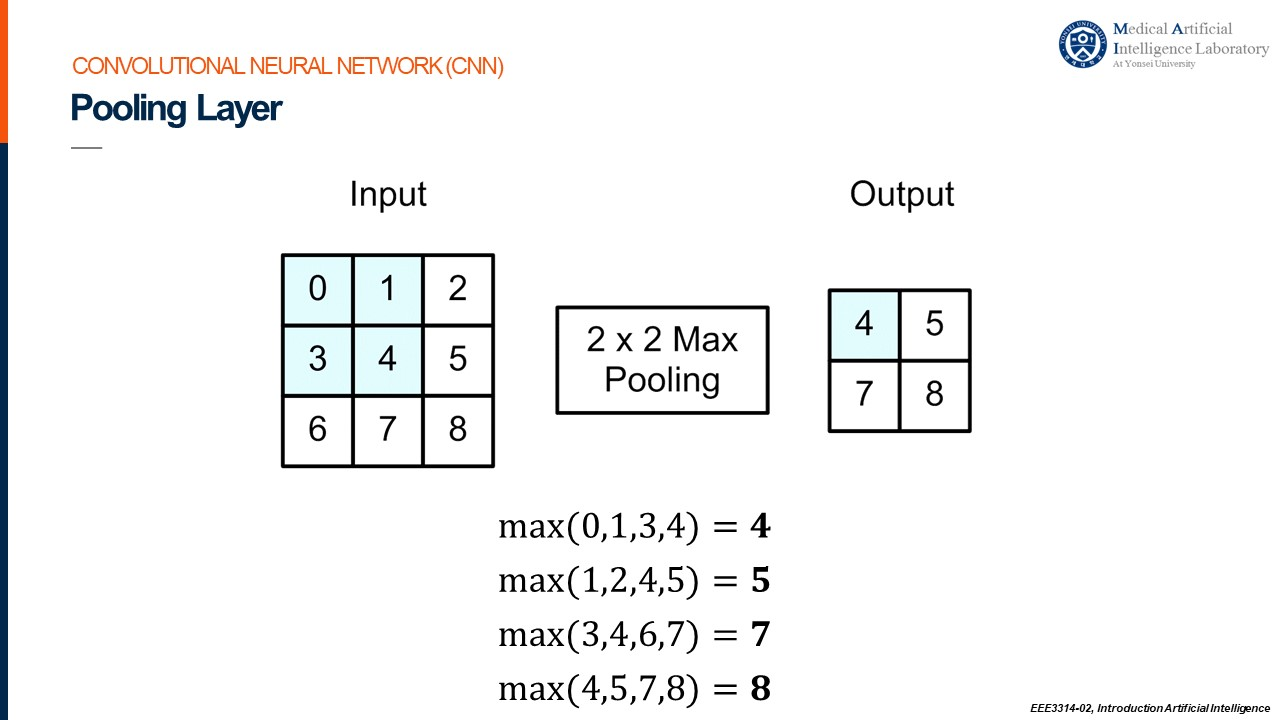

위 pooling operation을 ***pool2d*** 함수로 구현.\
input tensor ***X***와 ***pool size*** 를 받아서 output tensor ***Y*** 를 출력하는 함수.

#**Assignment 3-4**

***pool2d*** 함수 구현하기 \
***(Max pooling & Average pooling)*** \

***X***: input tensor, ***pool_size***: pooling size, ***model***: 'max' (max pooling) or 'avg' (average pooling), ***Y***: output tensor, 

In [ ]:
def pool2d(X, pool_size, mode='max'):
    # Compute 2D pooling
    # X: input tensor, pool_size: pooling size, mode: 'max' or 'avg'
    # Y: output tensor
    [R,C] = X.shape
    r = pool_size[0]
    c = pool_size[1]
    p = r*c
    output_sizeR = int((R-r) + 1) # Y의 row size 계산
    output_sizeC = int((C-c) + 1) # Y의 column size 계산
    Y = torch.zeros(output_sizeR, output_sizeC)
    if mode == 'max':
      dummy = torch.zeros(r,c)
      for i in range(output_sizeR):
        for j in range(output_sizeC):
          for k in range(r):
            for l in range(c):
              dummy[k,l] = X[i+k,j+l]
          Y[i,j] = torch.max(dummy)

    if mode == 'avg':
      for i in range(output_sizeR):
        for j in range(output_sizeC):
          for k in range(r):
            for l in range(c):
              Y[i,j] = Y[i,j] + X[i+k,j+l]
      Y = Y/p

    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])

pool2d(X, (2, 2), 'max') # 2 X 2 max pooling

In [ ]:
pool2d(X, (2, 2), 'avg') # 2 X 2 average pooling